## 强化图片

In [5]:
# 将所有的图片转成64x64的图片
from os import path, makedirs, listdir
from tensorflow.keras.preprocessing import image


def genDir(c, type):
    base_path = "./data"
    cf = path.join(base_path, f"cats_and_dogs/{type}")
    inner_path = path.join(cf, c)
    out_path = path.join(base_path, "cats_and_dogs_1", type, c)
    makedirs(out_path, exist_ok=True)
    return [cf, inner_path, out_path]


dataGen = image.ImageDataGenerator(
    rescale=1.0 / 255,  # 归一化
    rotation_range=20,
    width_shift_range=0.2,  # 水平随机平移0.2
    height_shift_range=0.2,  # 垂直随机平移0.2
    shear_range=0.2,  # 随机剪切变换0.2
    zoom_range=0.2,  # 随机缩放0.2
    horizontal_flip=True,  # 水平翻转
    fill_mode="nearest",  # 填充新创建像素的方法
)

classes = ["dogs", "cats"]
cfs = ["train", "validation"]


def gen():
    for j in cfs:
        for c in classes:
            cf, inner_path, out_path = genDir(c, j)
            batch_size = 32
            gen_data = dataGen.flow_from_directory(
                directory=cf,
                classes=[c],
                batch_size=batch_size,
                shuffle=True,
                save_to_dir=out_path,
                save_prefix="gen",
                target_size=[64, 64],
                class_mode="binary",
            )

            num_images = len(listdir(inner_path))
            steps = num_images // batch_size

            for i in range(steps):
                next(gen_data)


for i in range(10):
    gen()

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
Foun

## 训练

In [1]:
import os
import math
import warnings

warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.optimizers import Adam  # 优化深度学习模型的算法
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 构建卷积神经网络
model = tf.keras.Sequential([
    # 第一个卷积层
    # 生成32个特征 卷积大小3x3 激活函数 relu 输入图片的大小 64x6
    # 数据特征尺寸 (64-3)/1+1 = 62,62x62
    tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=[64, 64, 3]),
    tf.keras.layers.MaxPooling2D(2, 2),  # 池化层
    tf.keras.layers.Dropout(0.2),  # 正则化

    # 第二个卷积层
    tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    # 第三个卷积
    tf.keras.layers.Conv2D(128, [3, 3], activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),

    # 为全链路准备，转成1维
    tf.keras.layers.Flatten(),

    # 512个神经元
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# 打印模型的总结信息
model.summary()

# 配置训练器
model.compile(
    # 损失函数，用于衡量模型的预测值和实际值之间的差异
    # binary_crossentropy 二分类交叉熵损失函数，通常用于二分类问题，它计算的是两个概率分布之间的差异
    loss="binary_crossentropy",
    # 优化器用于更新模型的参数以最小化损失函数
    optimizer=Adam(learning_rate=1e-4),
    # 用于评估模型的性能。准确率（accuracy），是分类问题中常用的评价指标。它表示模型预测正确的样本占总样本的比例。在二分类问题中，准确率是衡量模型在测试集上表现的一个直观指标。
    metrics=["acc"]
)

# 数据预处理
# 读进来的数据会被自动转换成tensor(float32)格式，分别准备训练和验证
# 图像数据归一化（0-1）区间
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

trainPath = os.path.join('./data/cats_and_dogs_1/train')
testPath = os.path.join('./data/cats_and_dogs_1/validation')

train_generator = train_datagen.flow_from_directory(
    # 训练文件的位置，分类文件夹的父级文件夹
    directory=trainPath,
    # 训练 一批 次 的20张图片
    batch_size=20,
    # 训练图片的尺寸64x64
    target_size=(64, 64),
    # 参数决定了生成的标签数组的类型
    # binary 用于二分类任务：生成二值标签，即每个样本的标签是 0 或 1
    # categorical 用于多分类任务 生成分类标签，每个样本的标签是一个独热编码（one-hot encoded）数组
    # sparse 用于多分类任务 生成稀疏标签，即每个样本的标签是一个整数（表示类索引）
    # input 用于自编码器（autoencoder）等无监督学习任务 生成的标签是输入数据本身。即输出和输入是相同的
    class_mode="binary",
)

validation_generation = test_datagen.flow_from_directory(
    directory=testPath,
    batch_size=20,
    target_size=(64, 64),
    class_mode='binary'
)

# 训练网络模型
# steps_per_epoch相当给定一个停止条件，因为生成器会不断产生batch数据，说白了就是它不知道一个epoch里需要执行多少个step
train_num_dogs = len(os.listdir(os.path.join(trainPath, "dogs")))
train_num_cats = len(os.listdir(os.path.join(trainPath, "cats")))
validation_num_dogs = len(os.listdir(os.path.join(testPath, "dogs")))
validation_num_cats = len(os.listdir(os.path.join(testPath, "cats")))
epochs = 20
history = model.fit(
    # Input data
    train_generator,
    steps_per_epoch=None,
    epochs=20,
    validation_data=validation_generation,
    validation_steps=None,
    verbose=2,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453,569 (9.36 MB)

 Trainable params: 2,453,569 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

Found 19840 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.
Epoch 1/20
992/992 - 34s - 34ms/step - acc: 0.5795 - loss: 0.6645 - val_acc: 0.6469 - val_loss: 0.6358
Epoch 2/20
992/992 - 35s - 35ms/step - acc: 0.6861 - loss: 0.5888 - val_acc: 0.6759 - val_loss: 0.5990
Epoch 3/20
992/992 - 34s - 34ms/step - acc: 0.7144 - loss: 0.5524 - val_acc: 0.6824 - val_loss: 0.5873
Epoch 4/20
992/992 - 33s - 34ms/step - acc: 0.7371 - loss: 0.5238 - val_acc: 0.6976 - val_loss: 0.5699
Epoch 5/20
992/992 - 35s - 35ms/step - acc: 0.7536 - loss: 0.5010 - val_acc: 0.6910 - val_loss: 0.5856
Epoch 6/20
992/992 - 35s - 35ms/step - acc: 0.7704 - loss: 0.4755 - val_acc: 0.6951 - val_loss: 0.5806
Epoch 7/20
992/992 - 35s - 35ms/step - acc: 0.7872 - loss: 0.4523 - val_acc: 0.7090 - val_loss: 0.5598
Epoch 8/20
992/992 - 36s - 36ms/step - acc: 0.7983 - loss: 0.4298 - val_acc: 0.7333 - val_loss: 0.5265
Epoch 9/20
992/992 - 35s - 36ms/step - acc: 0.8114 - loss: 0.4131 - val_acc: 0.7306 - val_l

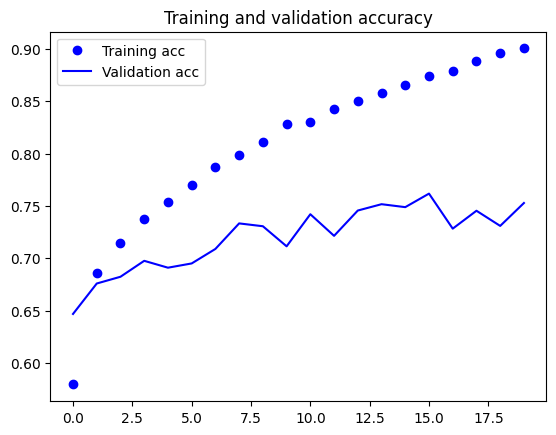

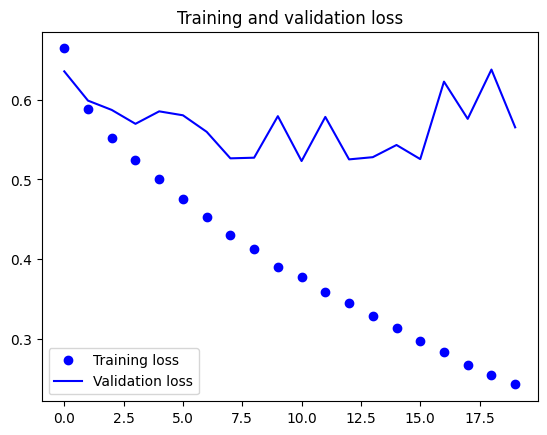

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()